# Can you find a better way to segment your customers?

## 📖 Background
You work for a medical device manufacturer in Switzerland. Your company manufactures orthopedic devices and sells them worldwide. The company sells directly to individual doctors who use them on rehabilitation and physical therapy patients.

Historically, the sales and customer support departments have grouped doctors by geography. However, the region is not a good predictor of the number of purchases a doctor will make or their support needs.

Your team wants to use a data-centric approach to segmenting doctors to improve marketing, customer service, and product planning. 

## 💾 The data

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

## 💪 Competition challenge

Create a report that covers the following:
1. How many doctors are there in each region? What is the average number of purchases per region?
2. Can you find a relationship between purchases and complaints?
3. Define new doctor segments that help the company improve marketing efforts and customer service.
4. Identify which features impact the new segmentation strategy the most.
5. Your team will need to explain the new segments to the rest of the company. Describe which characteristics distinguish the newly defined segments.

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

In [395]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

In [250]:
#Matplot lib configurations

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#Load datasets

doctors_df = pd.read_csv("Data/datacamp_workspace_export_2022-07-15 12_51_52.csv")
doctors_df.head()

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.00,34
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,--,0.48,29
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24


In [3]:
orders_df = pd.read_csv("Data/datacamp_workspace_export_2022-07-15 12_52_07.csv")
orders_df.head()

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False,Before
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False,NaN


In [4]:
complaints_df = pd.read_csv("Data/datacamp_workspace_export_2022-07-15 12_52_14.csv")

complaints_df.head()

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2


In [5]:
instructions_df = pd.read_csv("Data/datacamp_workspace_export_2022-07-15 12_52_21.csv")
instructions_df.head()

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes
3,AEBDAB,No
4,AJCBFE,Yes


## Data Wrangling

In [6]:
#Check general information about the doctors df
doctors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DoctorID        437 non-null    object 
 1   Region          437 non-null    object 
 2   Category        437 non-null    object 
 3   Rank            435 non-null    object 
 4   Incidence rate  437 non-null    float64
 5   R rate          437 non-null    float64
 6   Satisfaction    437 non-null    object 
 7   Experience      437 non-null    float64
 8   Purchases       437 non-null    int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 30.9+ KB


In [8]:
#Check for rows that are null in the Rank column of doctors df
doctors_df[doctors_df.Rank.isnull()]

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
110,BBAHCA,5 18,Specialist,NaN,6.0,3.14,--,1.43,7
217,AHABIB,5 18,General Practitioner,NaN,4.0,1.00,83.33,2.00,4


In [14]:
#Discovered that Satisfacrtion enter -- as empty/missing values
(doctors_df["Satisfaction"]=="--").sum() #187 missing values of experiences

187

In [17]:
#Check for duplicate values in dataframe
doctors_df.DoctorID.duplicated().sum() #No duplicate value

0

In [19]:
#Check for unique points in the region dataframe
doctors_df["Region"].unique()

array(['4 15', '1 8 T4', '1 9 T4', '1 10 T3', '1 14 T4', '1 10', '1 8 T3',
       '1 11', '1 12', '2 7 19', '1 19 T4', '2 11', '1 19 T3', '1 14',
       '1 12 T3', '1 13 T3', '1 19', '1 21 T3', '2 7 13', '1 14 T3',
       '1 12 T4', '1 13', '2 6 13', '2 7 9', '1 8', '1 9', '2 6 9',
       '2 7 12', '17', '1 9 T3', '2 6 8', '1 4CP', '5 18', '22 18',
       '2 7 8', '2 6 10', '2 7 14', '1 21 T4', '2 7 10', '2 6 12',
       '2 6 19', '3 16', '2 6 14', '23 3', '1 13 T4', '1 19 20'],
      dtype=object)

In [22]:
#Check unique categories un the doctors_df
doctors_df["Category"].unique()

array(['Specialist', 'General Practitioner'], dtype=object)

In [23]:
#Check unique points in the Rank column of dataframe to ensure aligns with description given above
doctors_df["Rank"].unique()

array(['Ambassador', 'Platinum Plus', 'Titanium', 'Silver Plus', 'Gold',
       'Platinum', 'Gold Plus', 'Silver', nan, 'Titanium Plus'],
      dtype=object)

In [25]:
#Have a general decription of numerical values present in the doctors_df
doctors_df[["Incidence rate", "R rate"]].describe()

,Incidence rate,R rate
count,437.000000,437.000000
mean,5.049748,1.098627
std,4.179639,0.731895
min,2.050000,0.000000
25%,3.000000,0.600000
50%,4.000000,1.000000
75%,6.000000,1.500000
max,49.000000,4.250000


In [30]:
(doctors_df["Incidence rate"] > 20).sum()

5

<AxesSubplot:>

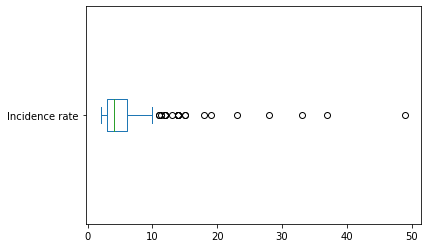

In [33]:
#Roughly check boxplot of the incidence_rate to check for outliers

doctors_df["Incidence rate"].plot(kind = "box", vert = False)

0


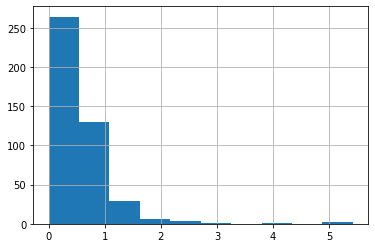

In [42]:
#Check experience column to ensure integers are greater than 0 and not -ve

doctors_df["Experience"].hist()

print((doctors_df["Experience"] < 0).sum())

In [47]:
doctors_df["Experience"].describe()

count    437.000000
mean       0.534027
std        0.603494
min        0.000000
25%        0.140000
50%        0.380000
75%        0.750000
max        5.420000
Name: Experience, dtype: float64

<AxesSubplot:>

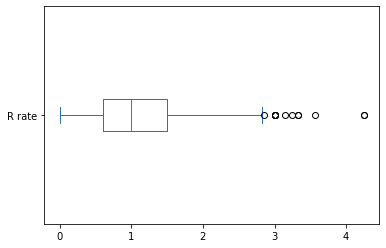

In [35]:
#Rough check of boxplot of R rate column of 
doctors_df["R rate"].plot(kind = "box", vert = False)

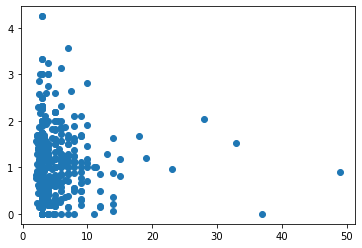

In [36]:
#Make scatter plot with x axis as Incidence Rate and  y axis as R rate
plt.scatter(doctors_df["Incidence rate"], doctors_df["R rate"]);

In [39]:
#Check the correlation between Incidence Rate and R rate
doctors_df["Incidence rate"].corr(doctors_df["R rate"])

-0.0422224826866023

In [50]:
doctors_df["Purchases"].value_counts().head()

4    72
3    56
5    41
7    32
8    32
Name: Purchases, dtype: int64

In [51]:
doctors_df["Purchases"].describe()

count    437.000000
mean      10.791762
std       11.429686
min        3.000000
25%        4.000000
50%        7.000000
75%       13.000000
max      129.000000
Name: Purchases, dtype: float64

In [89]:
orders_df.head(2)

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before


In [91]:
#General info about the orders_df
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DoctorID     257 non-null    object
 1   OrderID      257 non-null    object
 2   OrderNum     257 non-null    object
 3   Condition A  257 non-null    bool  
 4   Condition B  257 non-null    bool  
 5   Condition C  248 non-null    object
 6   Condition D  257 non-null    bool  
 7   Condition F  254 non-null    object
 8   Condition G  254 non-null    object
 9   Condition H  257 non-null    bool  
 10  Condition I  257 non-null    bool  
 11  Condition J  149 non-null    object
dtypes: bool(5), object(7)
memory usage: 15.4+ KB


In [90]:
#Check number of null values in the orders_df table
orders_df.isnull().sum()

DoctorID         0
OrderID          0
OrderNum         0
Condition A      0
Condition B      0
Condition C      9
Condition D      0
Condition F      3
Condition G      3
Condition H      0
Condition I      0
Condition J    108
dtype: int64

In [93]:
#Inspecting columns for condition c

orders_df["Condition C"].unique()

array([False, nan, True], dtype=object)

In [94]:
#Inspecting columns for condition F
orders_df["Condition F"].unique()

array([False, nan, True], dtype=object)

In [95]:
#Inspecting columns for condition G
orders_df["Condition G"].unique()

array([True, False, nan], dtype=object)

In [96]:
#Inspecting columns for condition J
orders_df["Condition J"].unique()

array(['Before', nan, 'After'], dtype=object)

In [102]:
#Checking the general information about the complaints table
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DoctorID        435 non-null    object
 1   Complaint Type  433 non-null    object
 2   Qty             435 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ KB


In [105]:
#Check value counts of complaint Type
complaints_df["Complaint Type"].value_counts()

Correct      205
Incorrect    118
Unknown      103
Specific       6
R&R            1
Name: Complaint Type, dtype: int64

In [111]:
#Checking the number of unique ID present in the dataset
complaints_df.DoctorID.nunique()

284

In [114]:
#Instructions Df general information
instructions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DoctorID      77 non-null     object
 1   Instructions  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [115]:
#Check the unique kind of instructions to map the decription given
instructions_df["Instructions"].unique()

array(['Yes', 'No'], dtype=object)

### Assessments
#### Doctors_df
- Missing values in Rank
- Satisfaction contains dashes as missing values and should be marked as float
- Category type of Rank should be ordered

#### Orders_df
- Missing values in condition C
- Missing values in Condition F
- Missing values in Condition G
- Missing values in Condition J

#### Complaints df
- Missing values in complaints type columns.

### Cleaning

In [61]:
#create copy of dataframe for keep
doctors_df_copy = doctors_df.copy()

In [52]:
doctors_df["Rank"].value_counts()

Ambassador       115
Platinum          77
Titanium          69
Platinum Plus     54
Gold Plus         50
Silver Plus       44
Gold              22
Silver             3
Titanium Plus      1
Name: Rank, dtype: int64

In [75]:
doctors_df["Purchases"].groupby(doctors_df["Rank"]).quantile(0.5).sort_values(ascending = False)

Rank
Ambassador       16.0
Titanium Plus    14.0
Titanium         10.0
Platinum Plus     8.0
Silver            7.0
Gold Plus         5.0
Platinum          5.0
Gold              4.0
Silver Plus       4.0
Name: Purchases, dtype: float64

From the above ordering we can spot that the number of purchases relates well with the Rank a person is, we will use this information to fill the missing values of the Rank column.

In [62]:
#Print rows of null values of the null values present in dataset
doctors_df[doctors_df["Rank"].isnull()]

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
110,BBAHCA,5 18,Specialist,NaN,6.0,3.14,--,1.43,7
217,AHABIB,5 18,General Practitioner,NaN,4.0,1.00,83.33,2.00,4


### Issue: Missing values in Rank
#### Define

- Fill missing values in index 110 with silver and fill with Silver and index 217 as Silver plus

#### Code

In [79]:
doctors_df.loc[110, "Rank"] = "Silver"
doctors_df.loc[217, "Rank"] = "Silver Plus"

#### Test

In [81]:
doctors_df.loc[[110, 217], :]

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
110,BBAHCA,5 18,Specialist,Silver,6.0,3.14,--,1.43,7
217,AHABIB,5 18,General Practitioner,Silver Plus,4.0,1.00,83.33,2.00,4


Satisfaction contains dashes as missing values and should be marked as float

In [85]:
(doctors_df["Satisfaction"] == "--").sum()/len(doctors_df)

0.4279176201372998

### Issue: Satisfaction contains dashes as missing values and should be marked as float

#### Define

> With up to 43% of the values in the columns missing, it would be preferred that the satisfaction column be dropped.

#### Code

In [87]:
doctors_df.drop(columns = "Satisfaction", inplace = True)

#### Test

In [88]:
"Satisfaction" in doctors_df.columns

False

### Issue: Category type of Rank should be ordered

#### Define
- Use pandas categorical ordering to order data type

#### Code

In [141]:
doctors_df["Rank"].unique()

#Ambassadors, followed by Titanium Plus, 
#Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.

array(['Ambassador', 'Platinum Plus', 'Titanium', 'Silver Plus', 'Gold',
       'Platinum', 'Gold Plus', 'Silver', 'Titanium Plus'], dtype=object)

In [149]:
len(doctors_df["Rank"])

437

In [153]:
ordered_list = ["Silver", "Silver Plus", "Gold", "Gold Plus", 
                "Platinum", "Platinum Plus", "Titanium",
               "Titanium Plus", "Ambassador"]

rank_type = pd.CategoricalDtype(ordered_list, ordered = True)
rank_type

doctors_df["Rank"] = doctors_df["Rank"].astype(rank_type)

#### Test

In [154]:
doctors_df["Rank"].unique()

['Ambassador', 'Platinum Plus', 'Titanium', 'Silver Plus', 'Gold', 'Platinum', 'Gold Plus', 'Silver', 'Titanium Plus']
Categories (9, object): ['Silver' < 'Silver Plus' < 'Gold' < 'Gold Plus' ... 'Platinum Plus' < 'Titanium' < 'Titanium Plus' < 'Ambassador']

### Orders_df cleaning

### Issue: Missing columns value

#### Define
- Orders df - condition C, F, G, missing values to be droppedCondition Ce
- Condition j column to dropped

#### Code

In [117]:
orders_df.shape

(257, 12)

In [118]:
col_drop = ["Condition C", "Condition F", "Condition G"]

for col in col_drop:
    orders_df = orders_df[~orders_df[col].isnull()]

In [121]:
orders_df.drop(columns = "Condition J", inplace = True)

In [123]:
for col in col_drop:
    orders_df[col] = orders_df[col].astype(bool)

#### Test

In [122]:
orders_df.shape

(248, 11)

In [124]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 0 to 256
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DoctorID     248 non-null    object
 1   OrderID      248 non-null    object
 2   OrderNum     248 non-null    object
 3   Condition A  248 non-null    bool  
 4   Condition B  248 non-null    bool  
 5   Condition C  248 non-null    bool  
 6   Condition D  248 non-null    bool  
 7   Condition F  248 non-null    bool  
 8   Condition G  248 non-null    bool  
 9   Condition H  248 non-null    bool  
 10  Condition I  248 non-null    bool  
dtypes: bool(8), object(3)
memory usage: 9.7+ KB


### Issue: Missing values in complaints type columns.

#### Define

- Rename missing values in the Compaints Type column in complaints_df to Unknown

#### Code

In [128]:
complaints_df["Complaint Type"].replace({np.nan: "Unknown"}, inplace=True)

#### Test

In [129]:
complaints_df["Complaint Type"].unique()

array(['Correct', 'Unknown', 'Incorrect', 'Specific', 'R&R'], dtype=object)

### Exploratory Data Analysis

In [137]:
doctors_df.head(1)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.9,1.2,49


In [133]:
doctors_df.describe(include = "object")

,DoctorID,Region,Category,Rank
count,437,437,437,437
unique,437,46,2,9
top,AHDCBA,1 13,Specialist,Ambassador
freq,1,34,367,115


In [134]:
orders_df.head(1)

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False


In [135]:
complaints_df.head(1)

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10


In [136]:
instructions_df.head(1)

,DoctorID,Instructions
0,ADIFBD,Yes


### Questions

- How many doctors are there in each region? What is the average number of purchases per region?
- Can you find a relationship between purchases and complaints?
- Define new doctor segments that help the company improve marketing efforts and customer service.
- Identify which features impact the new segmentation strategy the most.
- Your team will need to explain the new segments to the rest of the company. 
- Describe which characteristics distinguish the newly defined segments.

#### How many doctors are there in each region? What is the average number of purchases per region?

In [199]:
#Let us seperate the dataframe between the Specialist and General types of doctors, if there is difference

specialist_df = doctors_df[doctors_df["Category"] == "Specialist"]
general_df = doctors_df[doctors_df["Category"] == "General Practitioner"]

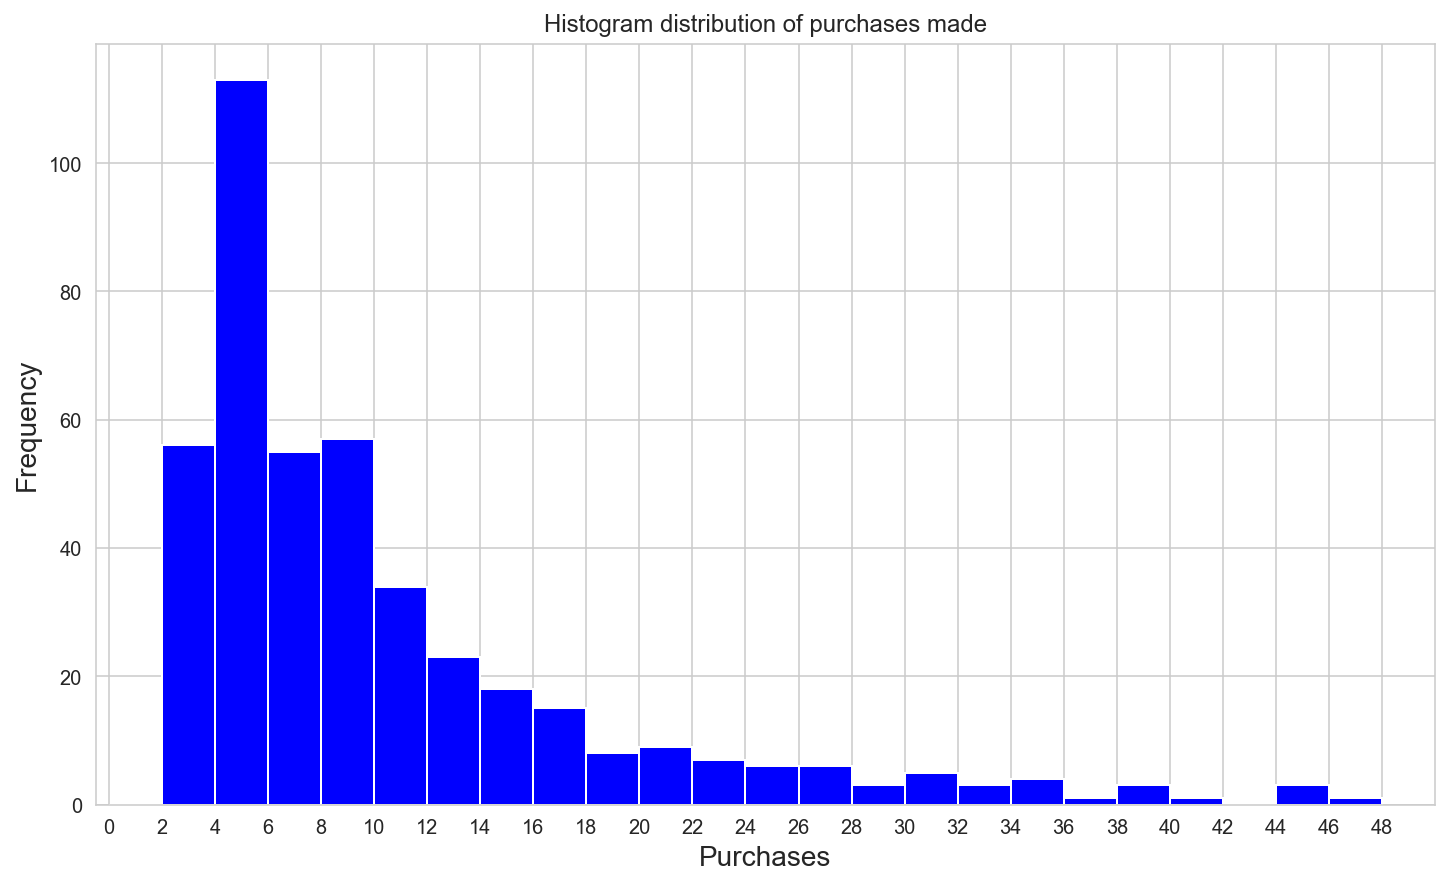

In [523]:
#Check the distribution of purchase of the different category
bins = np.arange(0, 50, 2)
doctors_df["Purchases"].hist(bins = bins, figsize=[12,7], color = "b")
plt.xlim(-0.5, 50)
plt.xticks(bins, bins)
plt.title("Histogram distribution of purchases made")
plt.xlabel("Purchases", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14);

**Observation**

- The Histogram is a right skewed histogram which shows that many extreme are to the right with the mode of the data being between purchases 4 to 6.

#### What is the distribution of Categories in the data

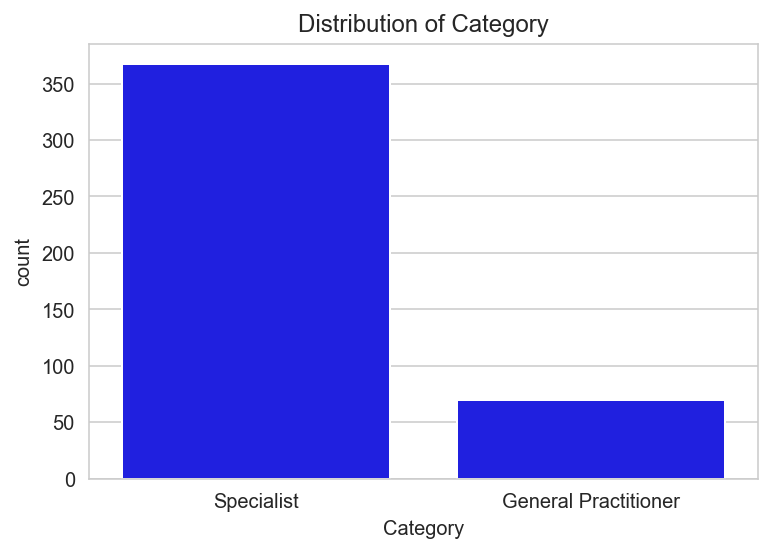

In [524]:
sns.countplot(data=doctors_df, 
             x = "Category", color="b")
plt.title("Distribution of Category");

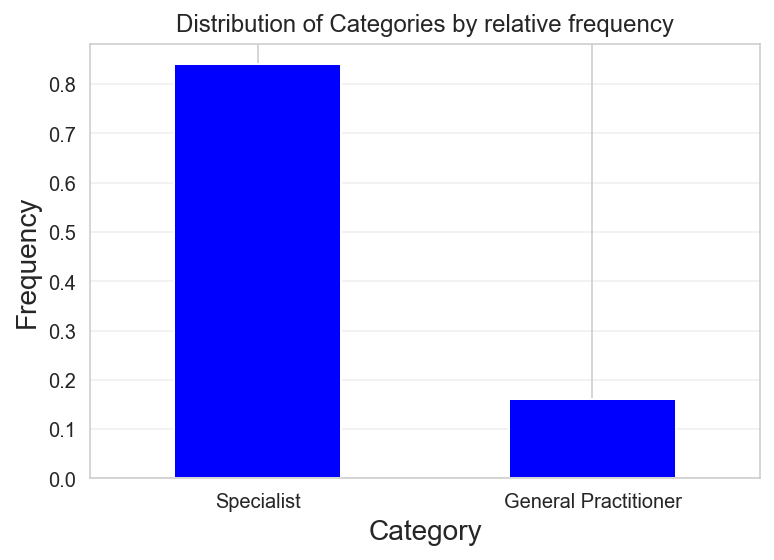

In [525]:
doctors_df["Category"].value_counts(normalize = True).plot(kind = "bar", color = "b")
plt.xticks(rotation = 0)
plt.grid(axis = "y", alpha = 0.3)
plt.title("Distribution of Categories by relative frequency")
plt.xlabel("Category", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14);

**Observation:**

- There are definitely more Specialist than General Practictioners. With about more than 80% being specialist.

In [180]:
#Using the groupby to group doctor counts and the average purchase by region

region_gb = (doctors_df.groupby("Region")["Purchases"].aggregate(["mean", "count"])
 .rename(columns = {"mean": "Average Purchase", "count": "Number of doctors"}))

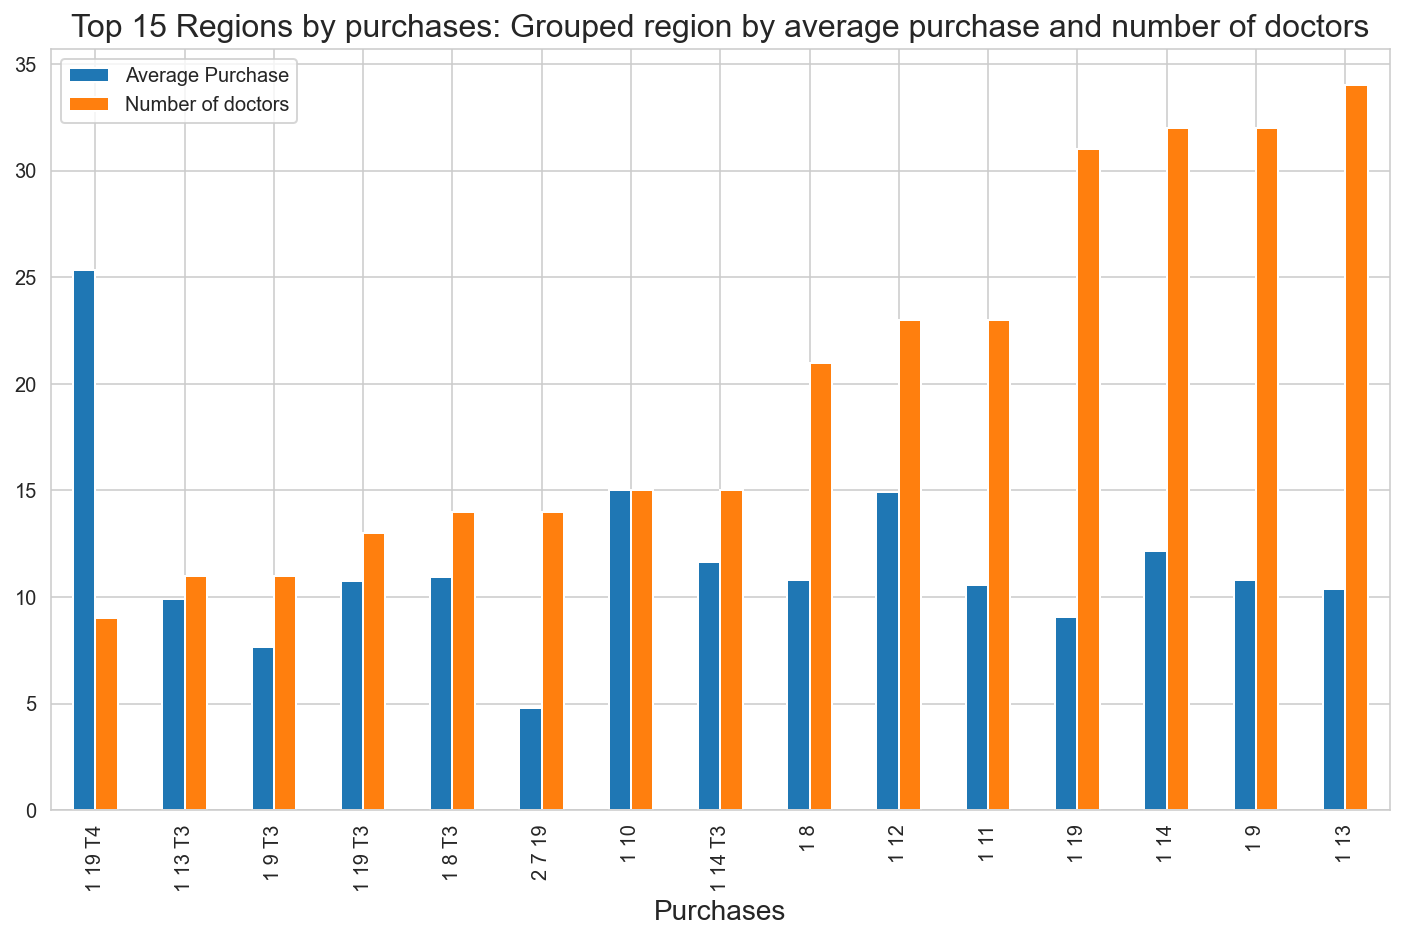

In [535]:
region_gb.sort_values("Number of doctors", ascending = True).tail(15).plot(kind = "bar", figsize = [12, 7])
plt.title("Top 15 Regions by purchases: Grouped region by average purchase and number of doctors", fontsize = 16)
plt.xlabel("Purchases", fontsize = 14);

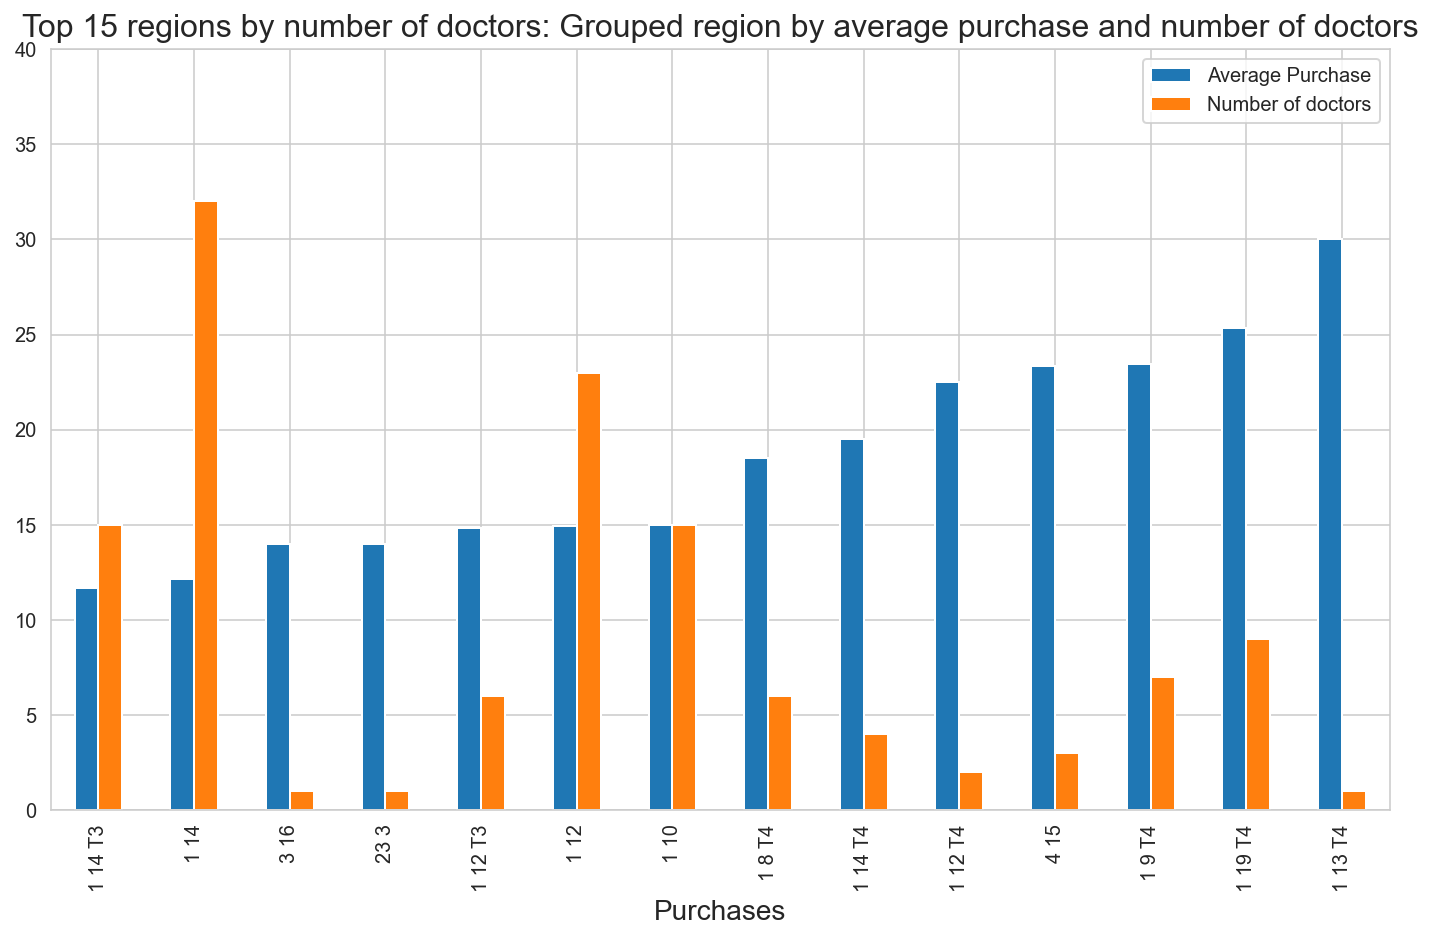

In [536]:
region_gb.sort_values("Average Purchase", ascending = True).tail(15).plot(kind = "bar", figsize = [12, 7])
plt.xlim(-0.5, 13.5)
plt.ylim(0, 40)
plt.title("Top 15 regions by number of doctors: Grouped region by average purchase and number of doctors", fontsize = 16)
plt.xlabel("Purchases", fontsize = 14);

**Observation:**
- From the plots above, although we expected that as the number of doctors increased, the average number of devices ordered would increase, but these plots do not appear a pattern of such.

#### The realtionship between purchases and category of doctors (Specialist and General Practictioners)

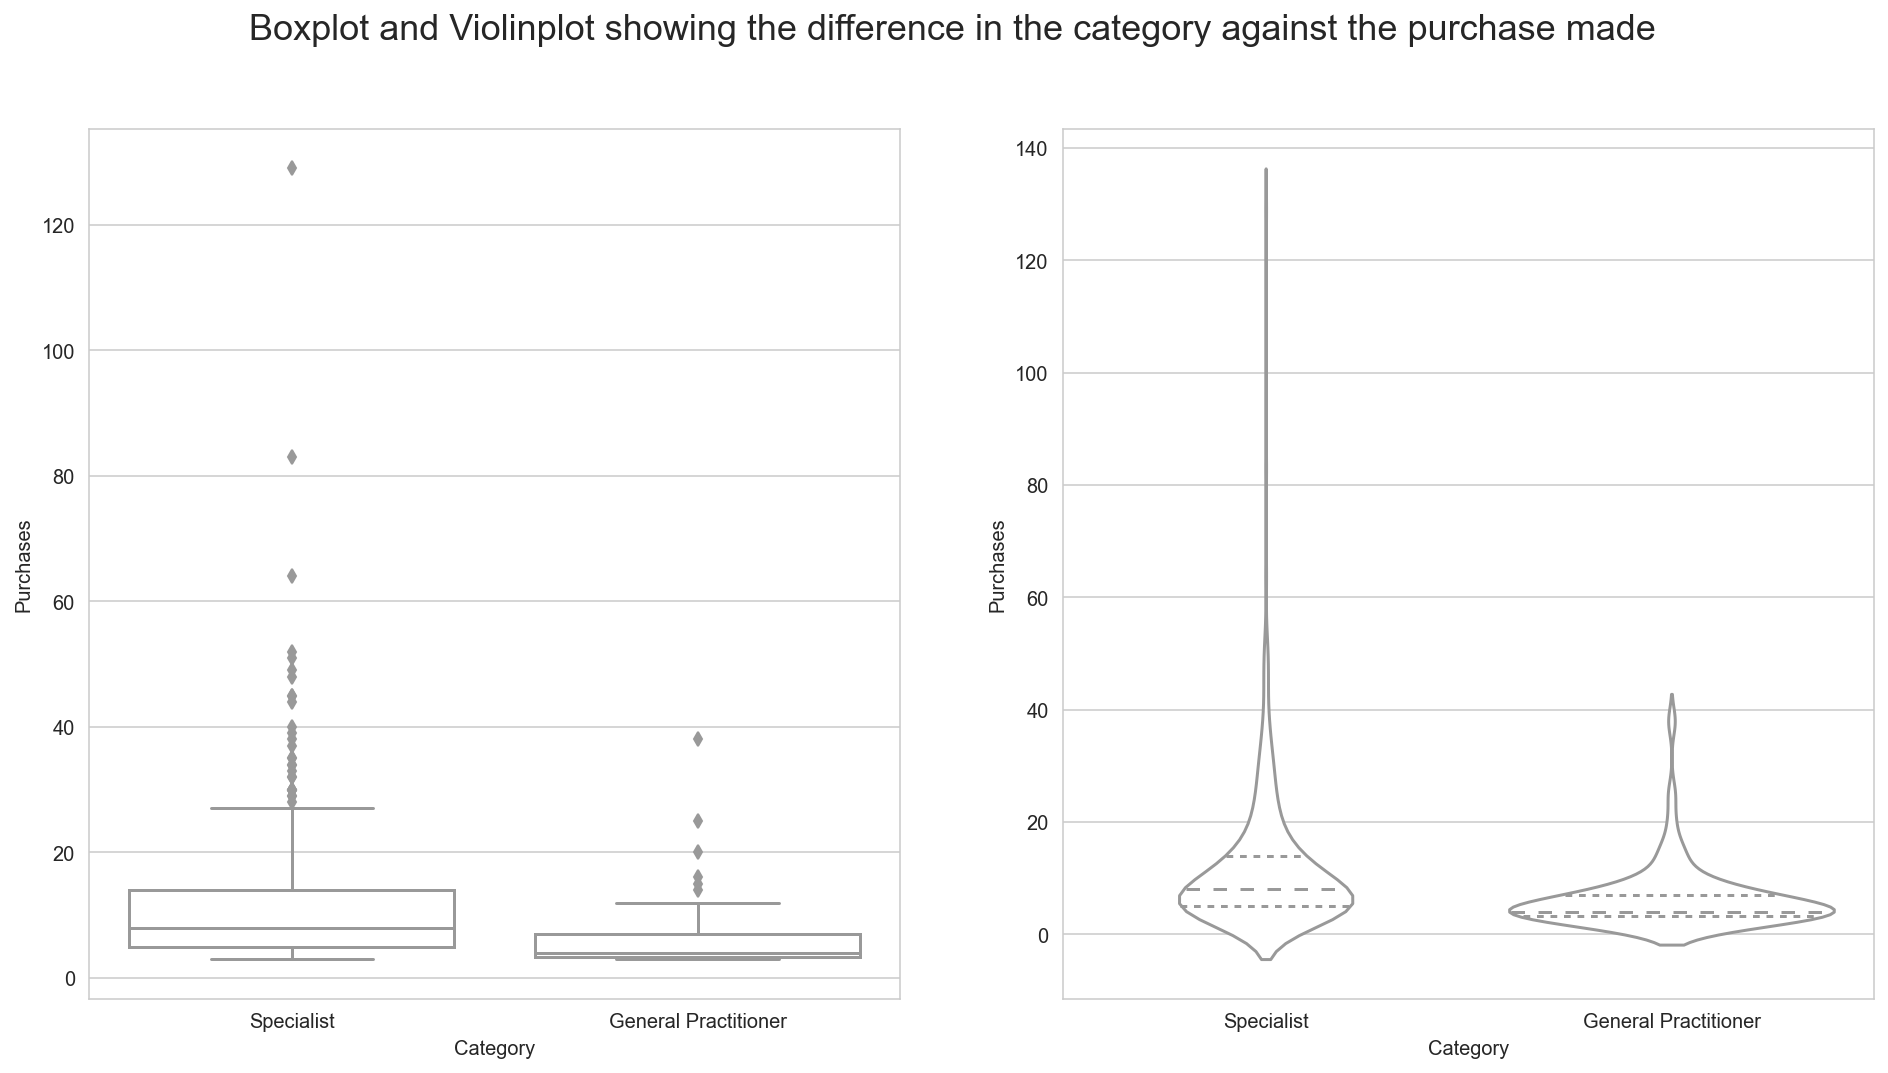

In [542]:
plt.figure(figsize = [16, 8])

plt.subplot(1, 2, 1)
sns.boxplot(x = doctors_df["Category"],
           y = doctors_df["Purchases"],
           color="white")

plt.subplot(1, 2, 2)
sns.violinplot(x = doctors_df["Category"],
           y = doctors_df["Purchases"], 
              color = "white", inner = "quartile")

plt.suptitle("Boxplot and Violinplot showing the difference in the category against the purchase made", 
             fontsize = 18);

In [255]:
print(specialist_df["Purchases"].median())
print(general_df["Purchases"].median())

8.0
4.0


**Observation**

- From the above, we see that there is a slight difference between the purchases made by Specialist and General Practicitioner.
- With a median of 4.0 for general practitioners and 8.0 for specialist.
- Also we see that most/mode purchases of general practictioners are so close to their median as 4.0 also
- But we see that specialist have a median higher than their mode and higher than 4.0 with a greater spread than general practictioners which we expect given the number of specialist that we have in the dataset when compared with the general practictioners.

#### Relationship between Complaints and Number of purchases

In [257]:
complaints_df.head(1)

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10


In [258]:
doctors_df.head(1)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.9,1.2,49


In [289]:
#merge both complaints and doctors_df together

complaint_pur = pd.merge(complaints_df, doctors_df, how = "inner", on = "DoctorID")

In [296]:
complaint_pur.head()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,EHEGI,Correct,1,1 8,Specialist,Platinum,3.00,1.50,0.25,4
1,EHEGI,Unknown,1,1 8,Specialist,Platinum,3.00,1.50,0.25,4
2,EHHGF,Correct,1,1 12 T3,Specialist,Titanium,2.50,1.86,0.57,7
3,EIFEJ,Correct,2,1 9 T4,Specialist,Ambassador,2.86,0.81,0.00,27
4,EIFEJ,Unknown,1,1 9 T4,Specialist,Ambassador,2.86,0.81,0.00,27


In [368]:
#Group dataframe by the doctorid
complaint_group_add = complaint_pur.groupby("DoctorID")[["Qty", "Purchases"]].sum()

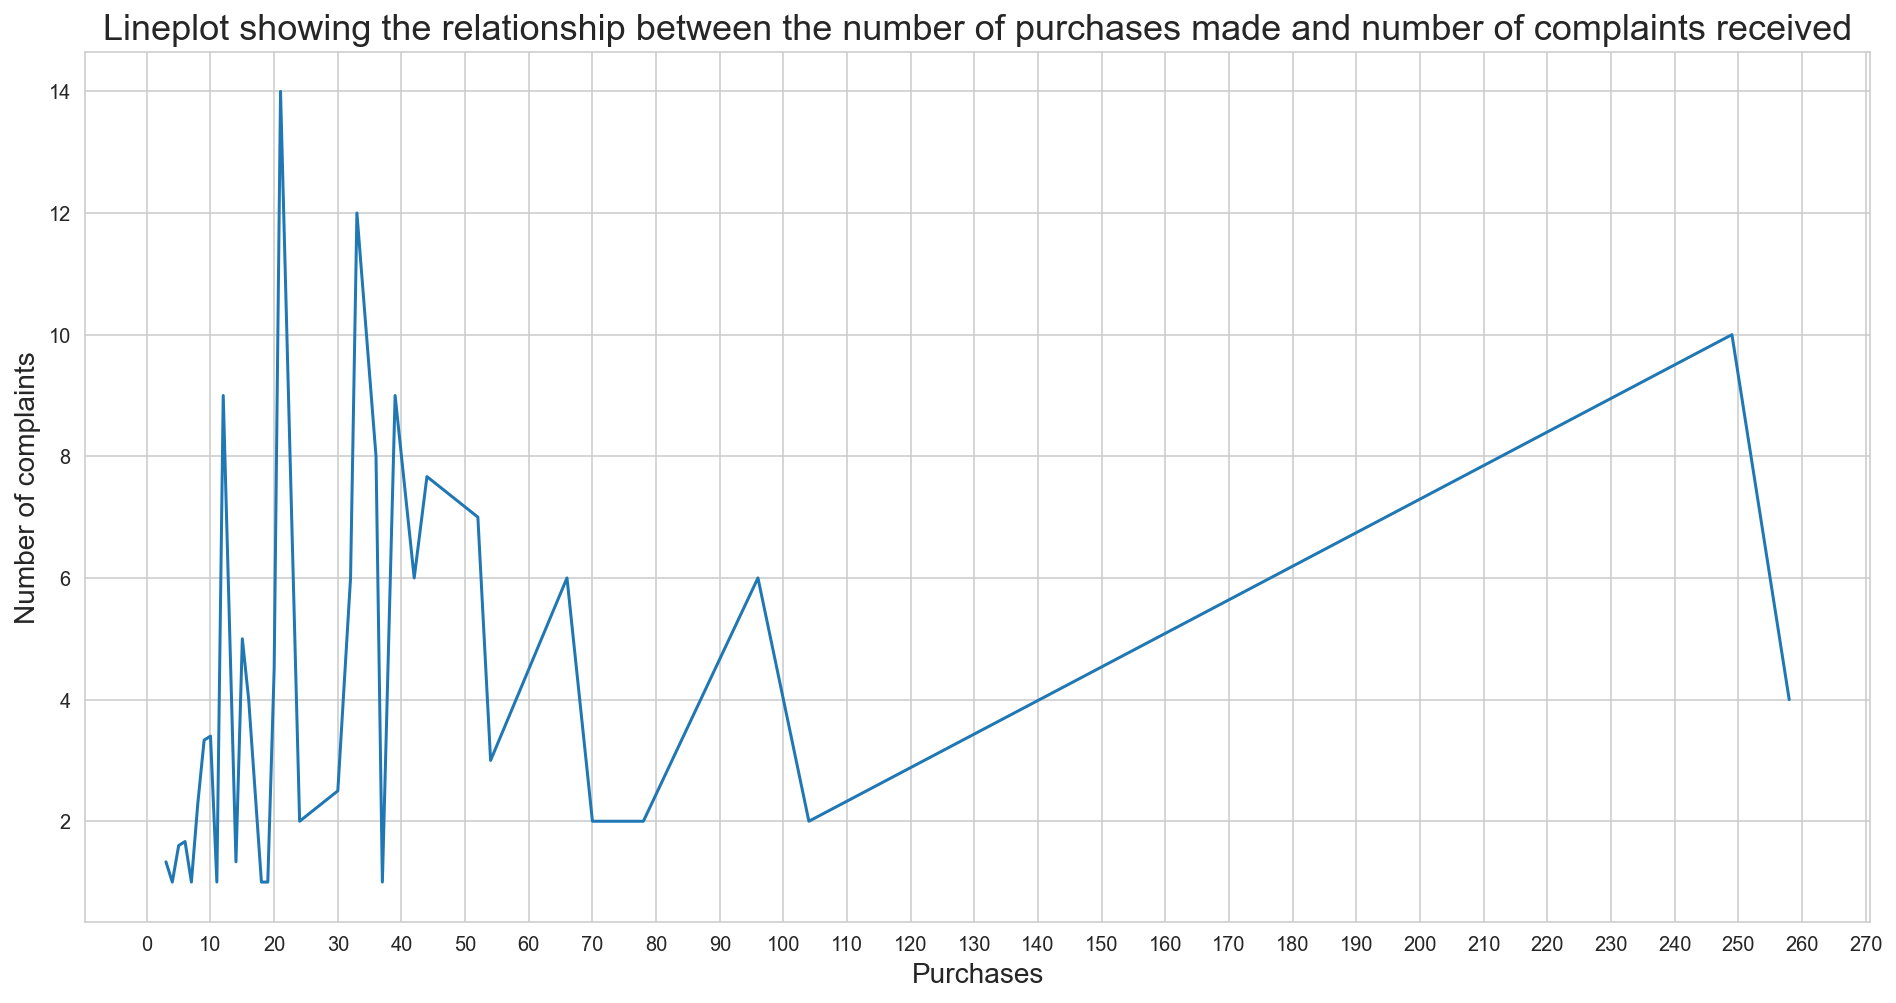

In [543]:
plt.figure(figsize = [16, 8])
sns.lineplot(x = complaint_group_add["Purchases"],
            y = complaint_group_add["Qty"], ci = None)
xticks = np.arange(0, 280, 10)
plt.xticks(xticks, xticks)
plt.title("Lineplot showing the relationship between the number of purchases made and number of complaints received", 
          fontsize = 18)
plt.xlabel("Purchases", fontsize = 14)
plt.ylabel("Number of complaints", fontsize = 14);

In [300]:
px.line(data_frame=complaint_pur,
       x = "Purchases", y = "Qty", color="Region")

**Observation**
- From the plots above, it is really hard and inconvinient to be able to pick out a trend or pattern that exists between the quantity of complaints and the amount of services purchases.
- However we see that purchases made between 0 - 30 purchases resulted into some spikes in the number of complaints received and followed an increasing pattern in the number of complaints but this effect gradually wears off as soon as the purchases made are above 30. 
- It follows sort of like a normal distribution where the number of complaints lodged is not about how much of the purchase made but a a normal distribution.

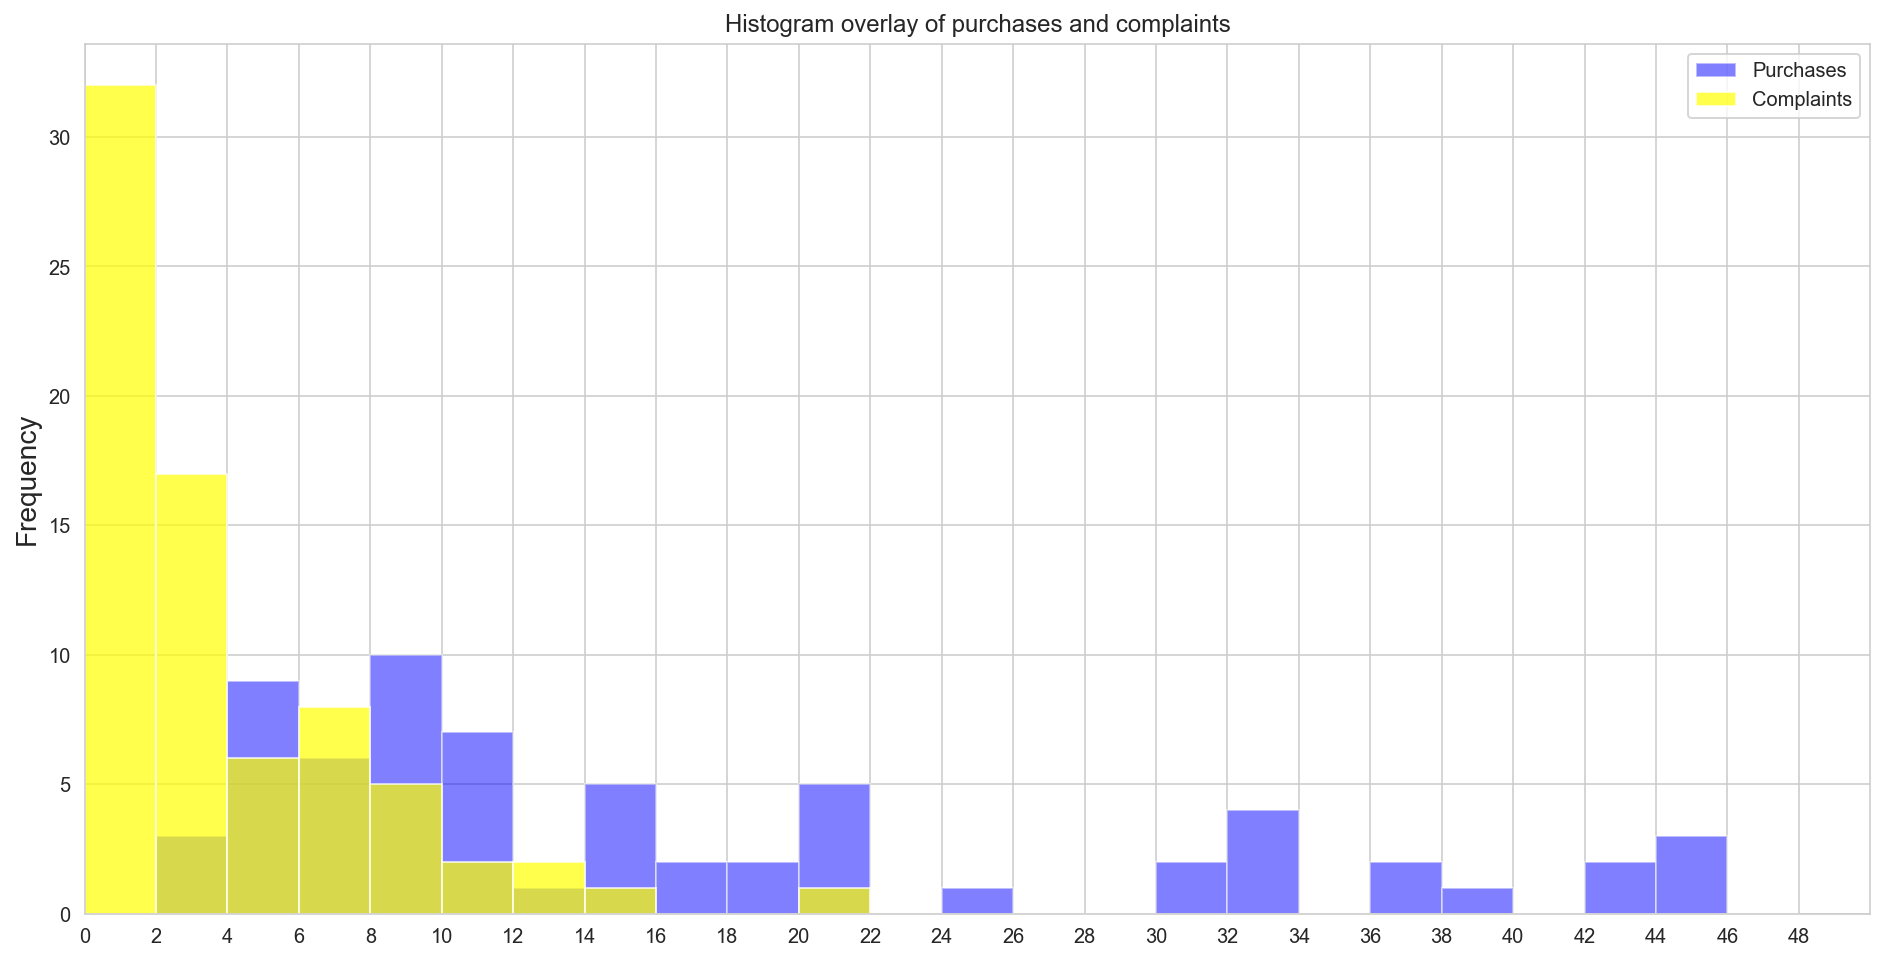

In [545]:
plt.figure(figsize = [16, 8])
bins = np.arange(0, 50, 2)
complaint_group_add["Purchases"].hist(bins = bins, alpha = 0.5, color = "blue")
complaint_group_add["Qty"].hist(bins = bins, alpha = 0.7, color = "yellow")
plt.xticks(bins, bins)
plt.xlim(0, 50)
plt.legend(["Purchases", "Complaints"])
plt.title("Histogram overlay of purchases and complaints")
plt.ylabel("Frequency", fontsize = 14);

### Using kprototype for clustering

In [302]:
doctors_df.head(1)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.9,1.2,49


In [369]:
orders_df.head(1)

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False


In [373]:
complaints_df.head()

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2


In [600]:
#combining the doctor_df and complains_df table

doctors_merge = pd.merge(complaints_df, doctors_df, how = "right", on = "DoctorID")
doctors_merge.sample()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
152,ABAIEG,Correct,1.0,1 11,General Practitioner,Gold,5.0,2.6,0.8,5


In [601]:
#Fill missing values from the merged dataframe as the following
#Complaint type as no complaint
#And Qty as 0

doctors_merge["Complaint Type"].fillna("No Complaints", inplace = True)
doctors_merge["Qty"].fillna(0, inplace = True)

In [602]:
#Test
doctors_merge.isna().sum()

DoctorID          0
Complaint Type    0
Qty               0
Region            0
Category          0
Rank              0
Incidence rate    0
R rate            0
Experience        0
Purchases         0
dtype: int64

#### Split the dataframe for use into the kprototype model

In [618]:
doctors_merge.head()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,AHDCBA,No Complaints,0.0,4 15,Specialist,Ambassador,49.0,0.90,1.20,49
1,ABHAHF,No Complaints,0.0,1 8 T4,General Practitioner,Ambassador,37.0,0.00,0.00,38
2,FDHFJ,No Complaints,0.0,1 9 T4,Specialist,Ambassador,33.0,1.53,0.00,34
3,BJJHCA,No Complaints,0.0,1 10 T3,Specialist,Ambassador,28.0,2.03,0.48,29
4,FJBEA,No Complaints,0.0,1 14 T4,Specialist,Ambassador,23.0,0.96,0.75,24


In [620]:
#Save file
doctors_merge.to_csv("Data/raw_doctors", index = False)

In [613]:
#Drop DoctorID

X = doctors_merge.drop(columns = ["DoctorID"])
X.head()

,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,No Complaints,0.0,4 15,Specialist,Ambassador,49.0,0.90,1.20,49
1,No Complaints,0.0,1 8 T4,General Practitioner,Ambassador,37.0,0.00,0.00,38
2,No Complaints,0.0,1 9 T4,Specialist,Ambassador,33.0,1.53,0.00,34
3,No Complaints,0.0,1 10 T3,Specialist,Ambassador,28.0,2.03,0.48,29
4,No Complaints,0.0,1 14 T4,Specialist,Ambassador,23.0,0.96,0.75,24


In [614]:
#scale all numerical values present

num_trans = StandardScaler().fit_transform(X[["Qty", "Incidence rate", "Experience", "R rate", "Experience", "Purchases"]])
X[["Qty", "Incidence rate", "Experience", "R rate", "Experience", "Purchases"]] = num_trans

In [615]:
X.head()

,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases
0,No Complaints,-0.404304,4 15,Specialist,Ambassador,10.941947,-0.297160,1.137682,2.796951
1,No Complaints,-0.404304,1 8 T4,General Practitioner,Ambassador,7.958297,-1.528994,-0.920733,1.975615
2,No Complaints,-0.404304,1 9 T4,Specialist,Ambassador,6.963747,0.565124,-0.920733,1.676947
3,No Complaints,-0.404304,1 10 T3,Specialist,Ambassador,5.720559,1.249476,-0.097367,1.303612
4,No Complaints,-0.404304,1 14 T4,Specialist,Ambassador,4.477371,-0.215038,0.365776,0.930277


In [554]:
#Convert dataframe into numpy array which is acceptable for kprototype

X = X.values
X

array([['No Complaints', -0.4043038799170635, '4 15', ...,
        -0.29716033023596766, 1.137681632515821, 2.7969511931253797],
       ['No Complaints', -0.4043038799170635, '1 8 T4', ...,
        -1.5289943749706258, -0.9207326417264851, 1.9756145407896555],
       ['No Complaints', -0.4043038799170635, '1 9 T4', ...,
        0.5651235010782931, -0.9207326417264851, 1.6769466672130284],
       ...,
       ['No Complaints', -0.4043038799170635, '1 19 T4', ...,
        -0.47509191447541826, -0.4575894300219661, 0.7809430464831475],
       ['No Complaints', -0.4043038799170635, '1 9', ...,
        -0.37928259988494495, -0.37182216859520334, 1.0049439516656178],
       ['No Complaints', -0.4043038799170635, '1 13', ...,
        0.6061846359027818, -0.2517480025977355, 3.9169557190377304]],
      dtype=object)

In [555]:
#Convert the numerical columns to float

X[:, 1] = X[:, 1].astype(float)
X[:, 5] = X[:, 5].astype(float)
X[:, 6] = X[:, 6].astype(float)
X[:, 7] = X[:, 7].astype(float)
X[:, 8] = X[:, 8].astype(float)

In [556]:
#Create list for categorical index
cat_index = [0, 2, 3, 4]

In [558]:
#Plot the elbow curve after fitting the data to choose the eventual number of clusters

no_clusters = range(1, 18)
error_metrics = []

for k in no_clusters:
    
    #Instantiate model
    test_model = KPrototypes(n_clusters = k, init="Huang", random_state=42, verbose=0)
    #Use mdoel to fit predict clusters
    test_model.fit_predict(X, categorical = cat_index)
    #Append error to the list
    error_metrics.append(test_model.cost_)
    pass
print(error_metrics)

[2939.499999999997, 2555.242209089429, 2240.3545618543303, 1979.647203559916, 1770.106770647551, 1577.9997924492309, 1458.146992992709, 1345.5351901654856, 1275.5206253536437, 1180.542754485163, 1128.192171756449, 1075.6450465539865, 1053.9237303975972, 1009.4253356143419, 992.473884100458, 965.3940465284991, 944.0370077792609]


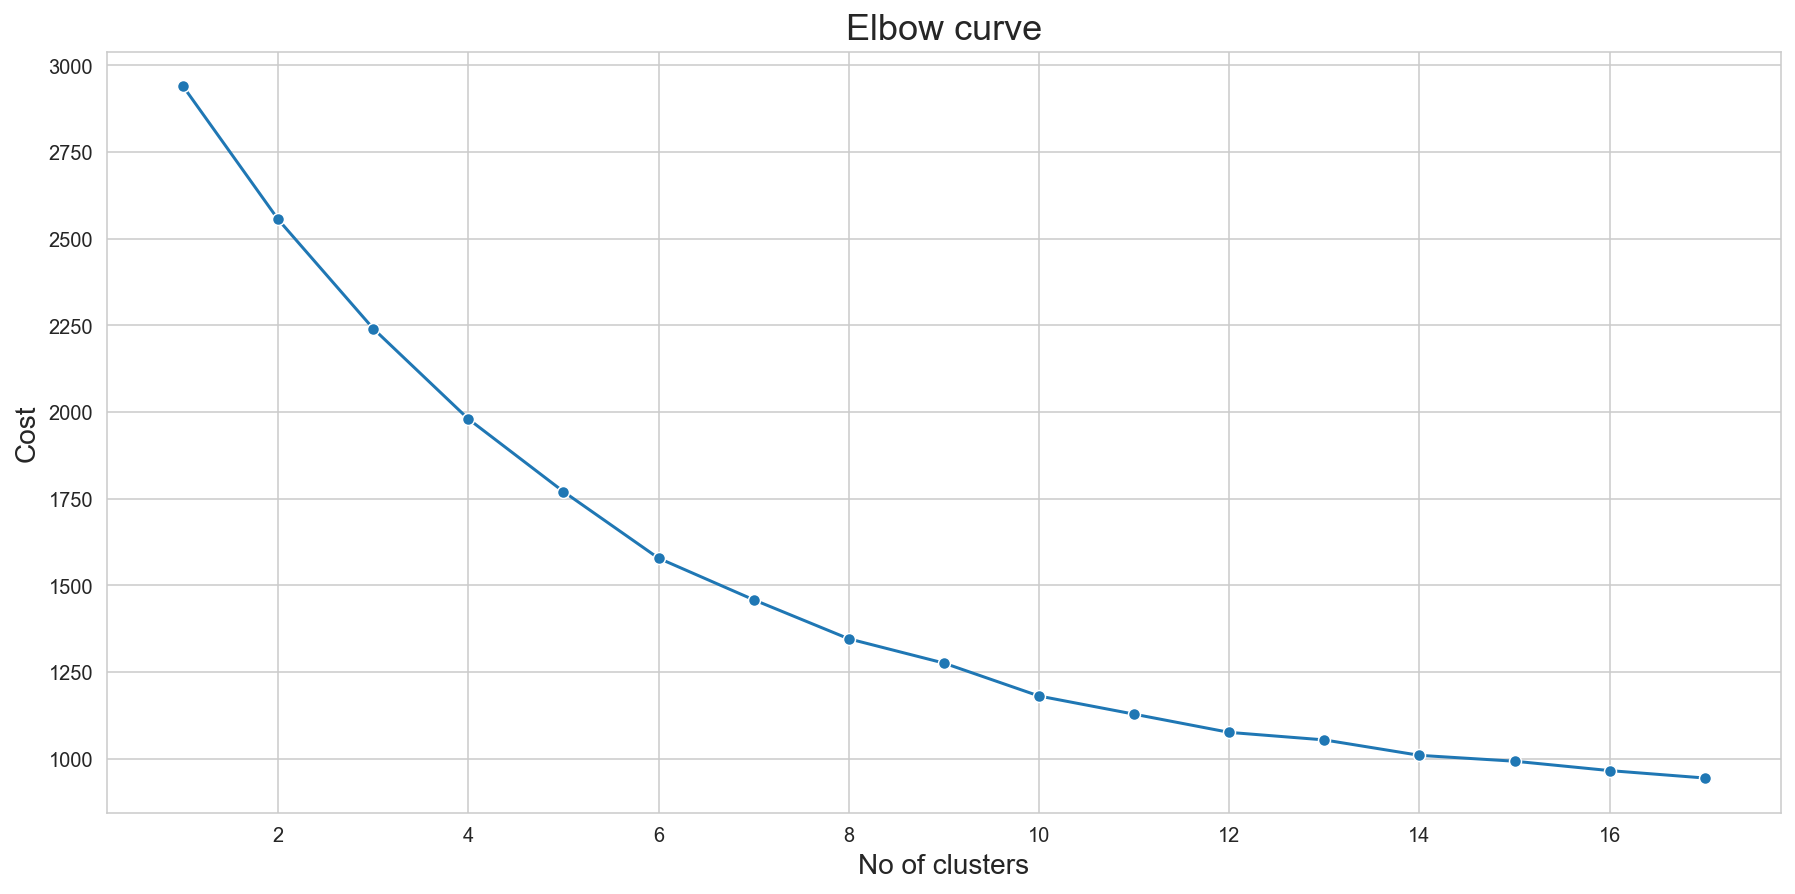

In [429]:
#Plot elbow plot
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x=no_clusters, y=error_metrics, marker="o", dashes=False)
ax.set_title('Elbow curve', fontsize=18)
ax.set_xlabel('No of clusters', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)
#ax.set(xlim=(start-0.1, end+0.1))
plt.plot();

From the above elbow curve, we see that clusters between 10 to 12  would seem like the number of clusters that would be of interest.

> On iteration we went ahead to use 5 clusters

In [559]:
#Let us go with 5 number of clusters

model = KPrototypes(n_clusters=5, init="Huang", random_state=42, verbose = 0)
clusters = model.fit_predict(X, categorical = cat_index)

In [560]:
#Make centroids into a dataframe
pd.DataFrame(model.cluster_centroids_)

,0,1,2,3,4,5,6,7,8
0,2.9671980578738952,0.09148021351004514,0.2797693519949782,0.04453890051289945,0.13156668499457225,Correct,1 8 T3,Specialist,Titanium
1,-0.24955436651342017,-0.1927574387811485,0.9726823428973778,0.6451677615025687,-0.26600602833851844,No Complaints,1 19,Specialist,Platinum
2,0.18008978930003605,-0.09326501855601271,-0.06406580729291095,0.011271599111003618,2.6091524544370444,No Complaints,1 14,Specialist,Ambassador
3,-0.4043038799170634,6.111275083832148,0.09389809666392379,-0.23704504349600478,1.4102789229481831,No Complaints,1 10 T3,Specialist,Ambassador
4,-0.24037070598534382,-0.05770559068742014,-0.5180374975164896,-0.32558242765207945,-0.22949581928560395,No Complaints,1 13,Specialist,Ambassador


From the above, we can quickly spot the categorical variables that are used in the kmodes algorithm part of the kprototypes algorithm. However, some categorical variables seem to possess dominant features in their category that is used in all clusters. For instance, each cluster uses Specialist in their category of doctor.

We should add the clusters into the dataframe as a label and seek to gain insights on the datasets and the clusters formed.

In [561]:
doctors_merge["Cluster Class"] = clusters

In [562]:
doctors_merge.head()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases,Cluster Class
0,AHDCBA,No Complaints,0.0,4 15,Specialist,Ambassador,49.0,0.90,1.20,49,3
1,ABHAHF,No Complaints,0.0,1 8 T4,General Practitioner,Ambassador,37.0,0.00,0.00,38,3
2,FDHFJ,No Complaints,0.0,1 9 T4,Specialist,Ambassador,33.0,1.53,0.00,34,3
3,BJJHCA,No Complaints,0.0,1 10 T3,Specialist,Ambassador,28.0,2.03,0.48,29,3
4,FJBEA,No Complaints,0.0,1 14 T4,Specialist,Ambassador,23.0,0.96,0.75,24,3


In [563]:
doctors_merge.tail()

,DoctorID,Complaint Type,Qty,Region,Category,Rank,Incidence rate,R rate,Experience,Purchases,Cluster Class
483,AIABDJ,Unknown,1.0,1 10,Specialist,Ambassador,2.18,0.80,0.77,35,2
484,BBAJCF,Incorrect,1.0,1 9 T4,Specialist,Ambassador,2.17,1.68,0.11,19,4
485,GGCFB,No Complaints,0.0,1 19 T4,Specialist,Ambassador,2.14,0.77,0.27,22,4
486,FDCEG,No Complaints,0.0,1 9,Specialist,Ambassador,2.13,0.84,0.32,25,4
487,EIEIB,No Complaints,0.0,1 13,Specialist,Ambassador,2.05,1.56,0.39,64,2


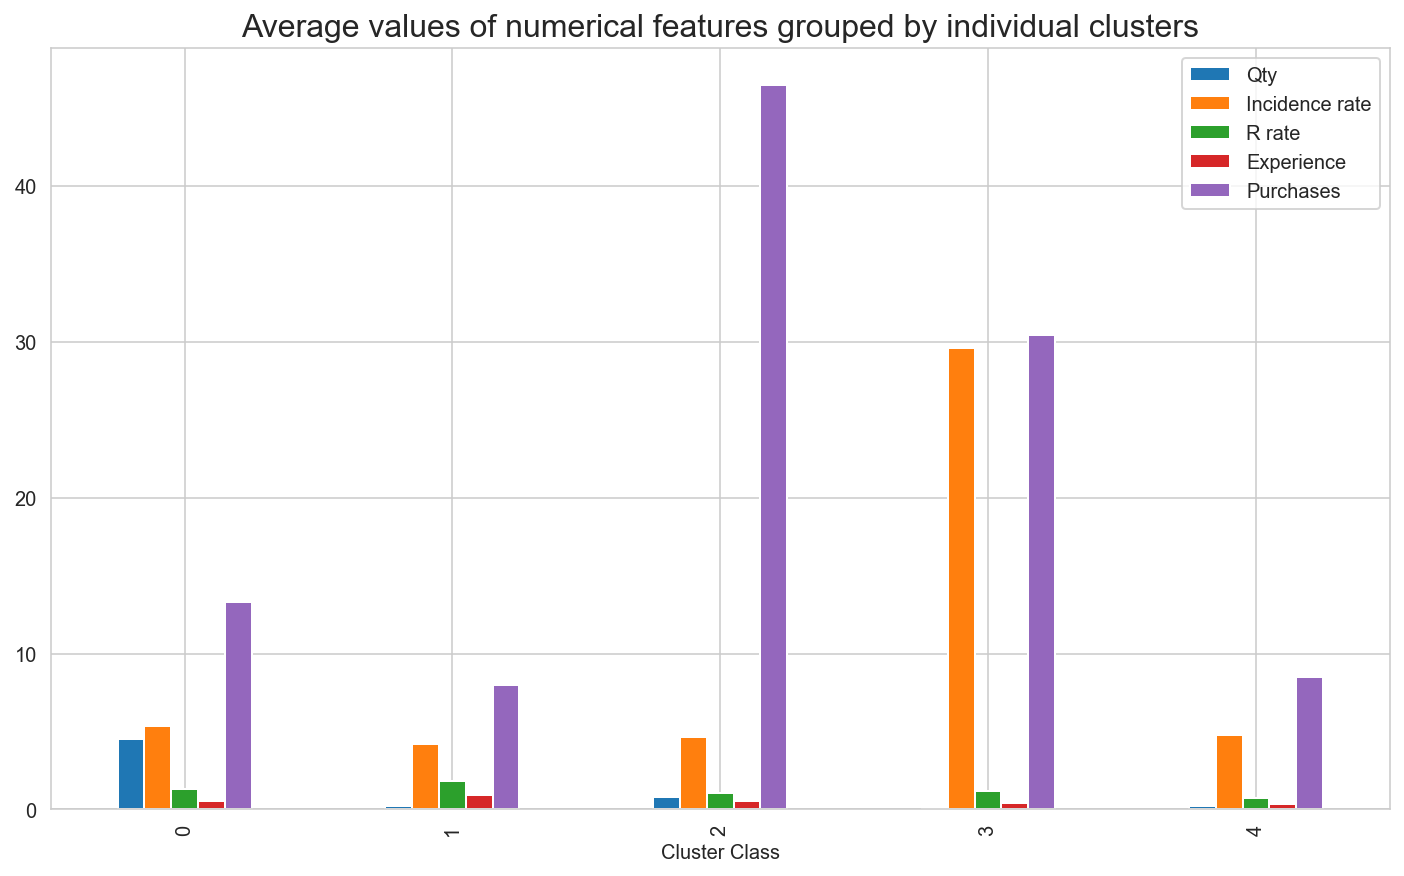

In [567]:
#Group by the cluster class

doctors_merge.groupby("Cluster Class")[["Qty", "Incidence rate", "R rate", "Experience", "Purchases"]].mean().plot(kind = "bar",
                                                                                                                  figsize = [12,7])
plt.title("Average values of numerical features grouped by individual clusters", fontsize = 16);

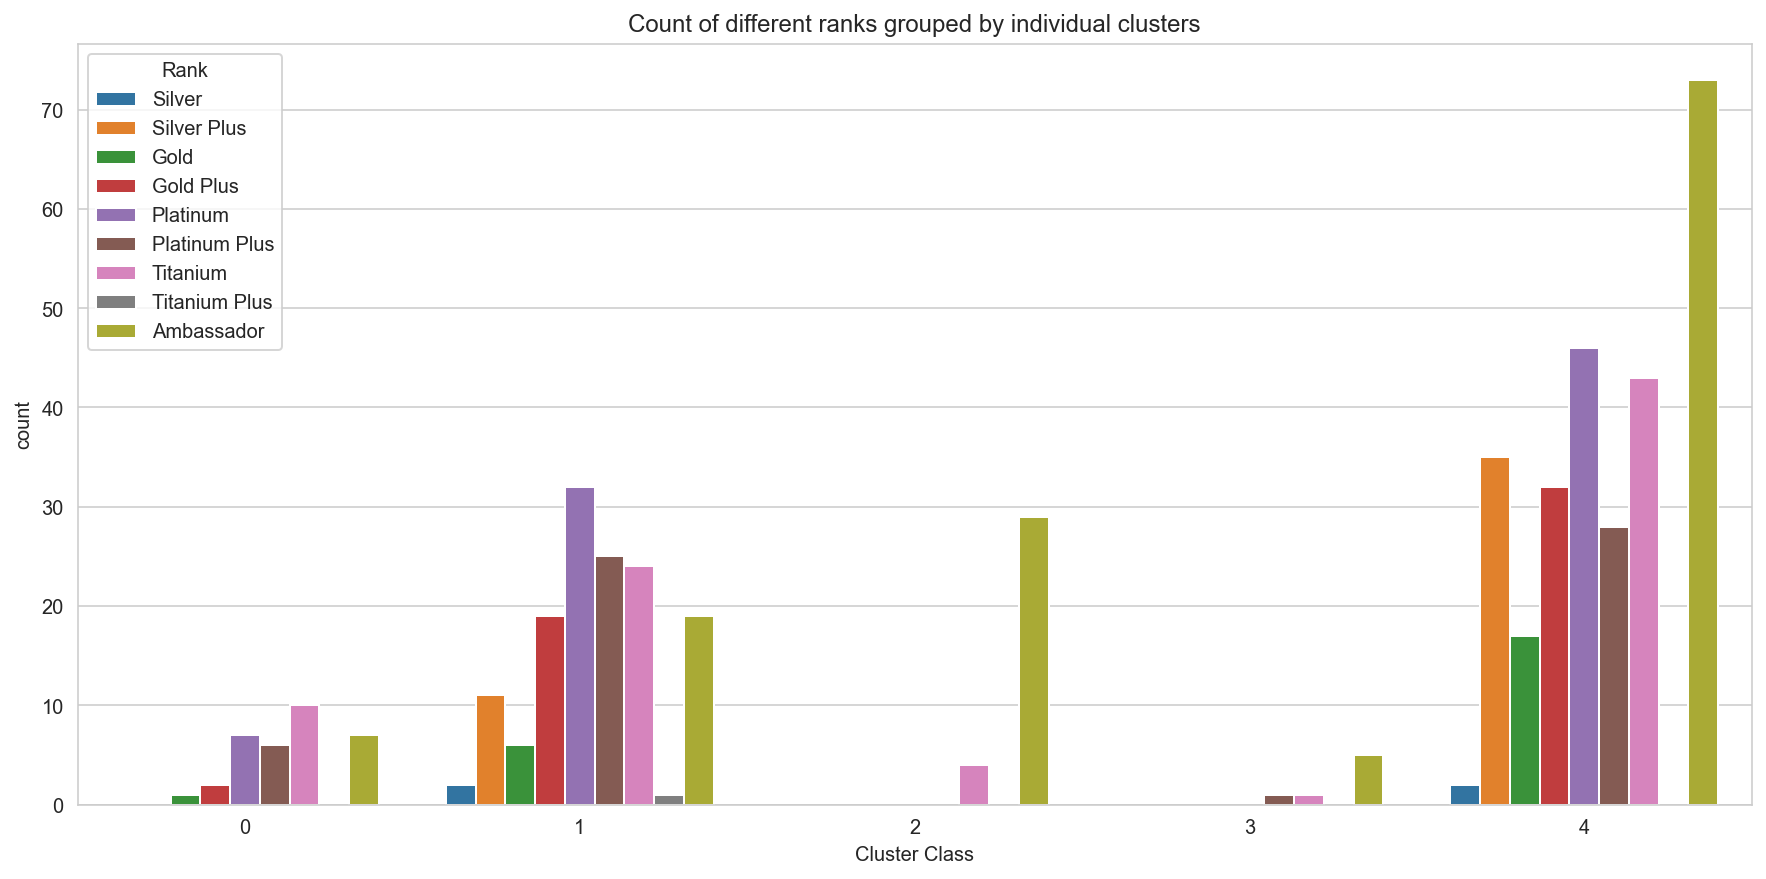

In [568]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.countplot(data=doctors_merge, x = "Cluster Class", hue = "Rank")
plt.title("Count of different ranks grouped by individual clusters");

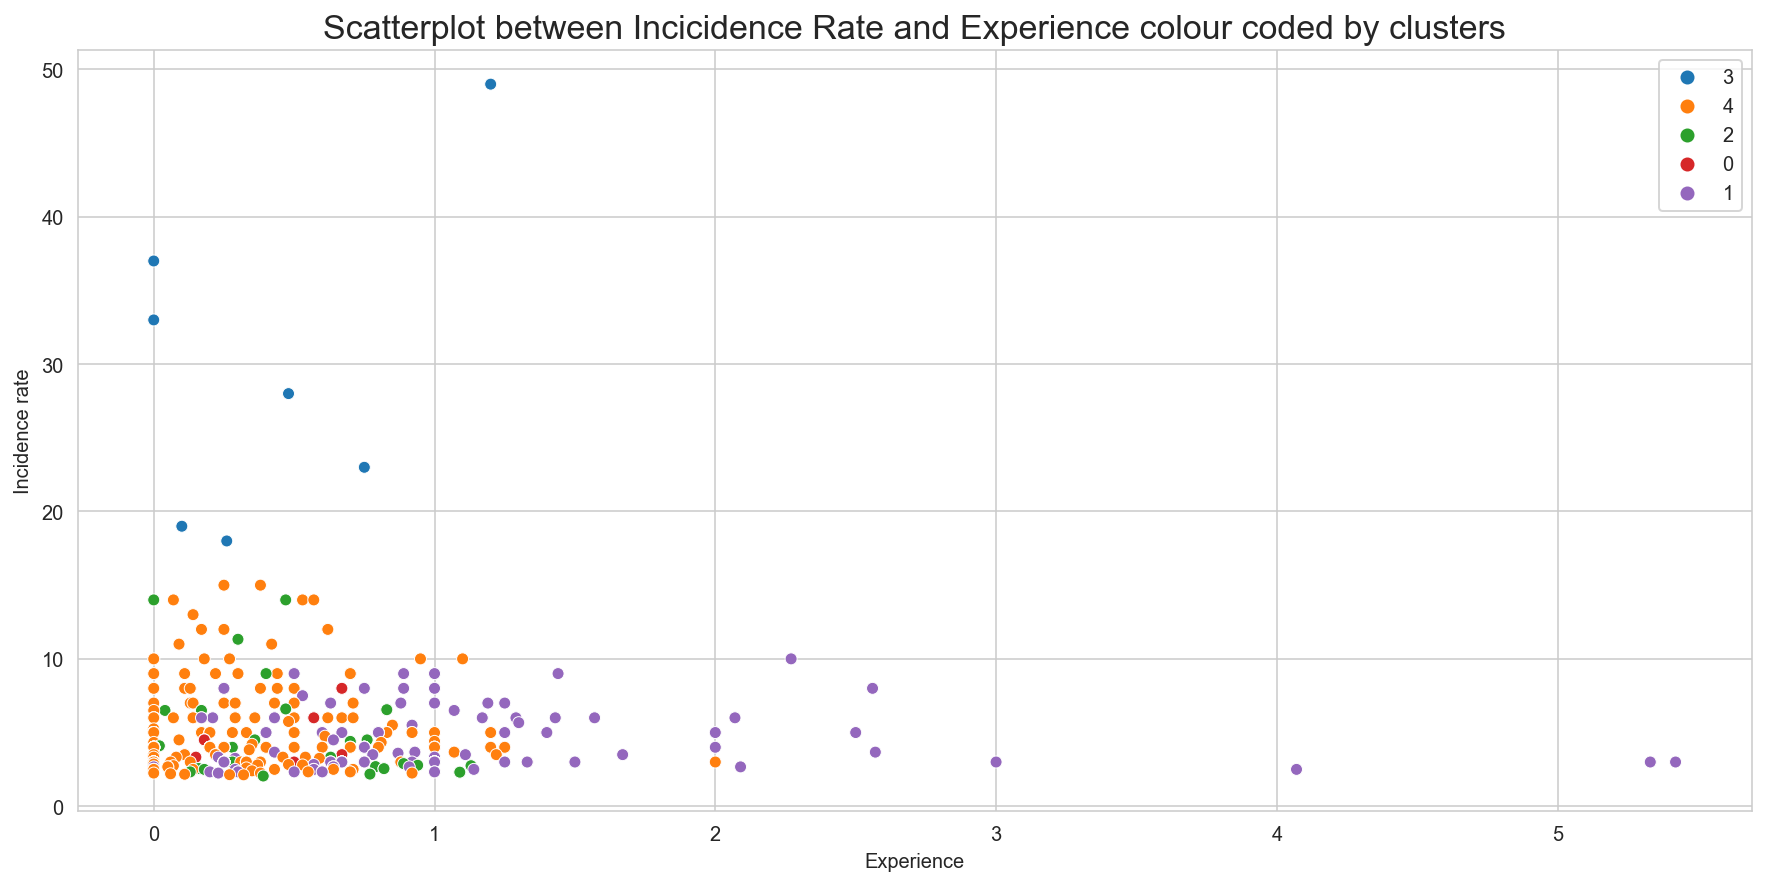

In [571]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

sns.scatterplot(data=doctors_merge, x = "Experience", y = "Incidence rate", hue = clusters.astype(str))
plt.title("Scatterplot between Incicidence Rate and Experience colour coded by clusters", fontsize = 17);

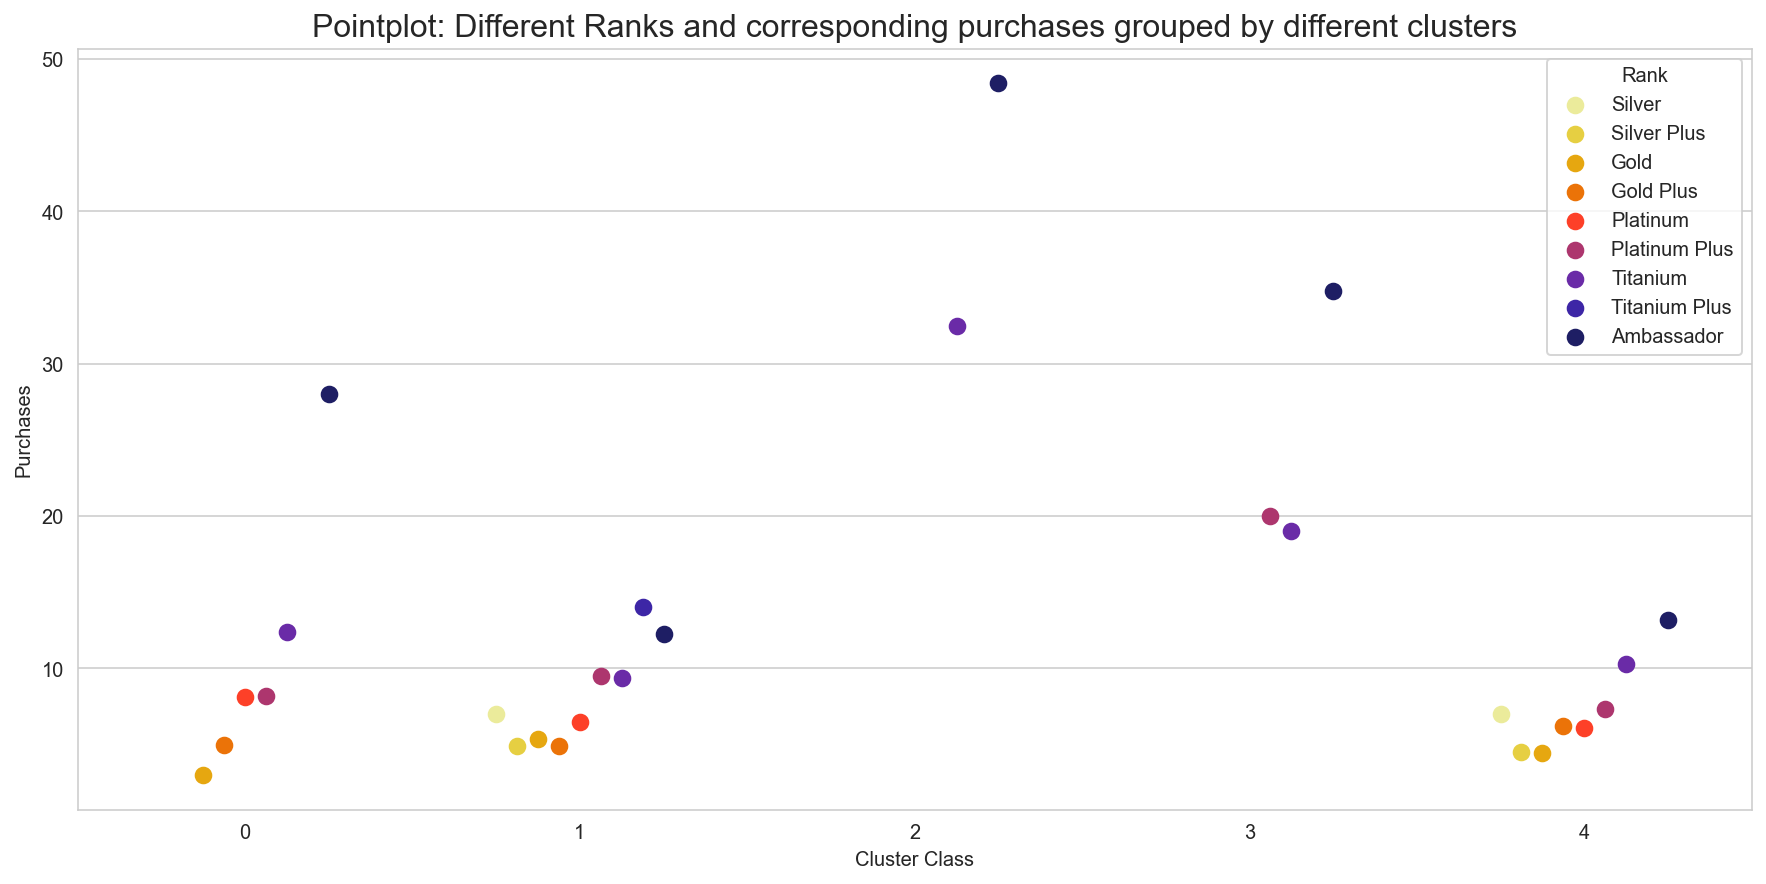

In [574]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.pointplot(data = doctors_merge, x = "Cluster Class",
             y = "Purchases", hue = "Rank", palette = "CMRmap_r",
             linestyles="", dodge = 0.5, ci = None)

plt.title("Pointplot: Different Ranks and corresponding purchases grouped by different clusters", fontsize = 16);

From the plots above, we can go on to describe the clusters formed in the following ways:

**Cluster 0:** They have most of their mean purchases around 10+ but their ambassador ranking personnel have a mean purchase of close to 30. However this particular cluster have the highest complaints among all other clusters, which is significantly higher than all other clusters. The ranking do no begin at silver, it rather begins at gold and goes all the way to Ambassaor, skipping Titanium plus.

**Cluster 1:** Although the scatterplot is hard to interpret, we do see that that Cluster 1 distributed accross difference experience range. However, above experience of 1, not many kind of clusters are found there and the cluster well dominates the field. The average purchase is below 10. It contains all ranks with the silver rank up to the gold rank clusterred around the same number of purchase, less than 10 and the higher ranks clustered around region of 10 or greater but less than 20.

**Cluster 2:** They have an average purchase greater than 40, with only titanium rank and ambassador rank present in the cluster. The titanium rank have their average purchases greater than 30 and the average purchases of their ambassadors greater than 40 and close to 50.

**Cluster 3:** It contains only three rank, Platinium Plus, Titanium and Ambassadors with average purchase of 30. However, they are spectacular for their high incidence rate among all other clusters. By looking at the scatterplot also, we discover that most of the clusters are above 20 and are the highest incidence rate in all of the data points in the scatterplot.

**Cluster 4:** Cluster 4 looks a lot like cluster 1 with very little difference. The difference is that cluster 4 has Titanium plus in the lower price region clustring with the likes of silver, dilver plus and lower ranks.

- The platinium rank seem to have fairly constant purchase made accross all clusters that they are present in.

### Why 5 Clusters?
> While I spotted from above that the ideal number of clusters will be between 10 to 12 and said I would go ahead to use 10 clusters. I ended up using 5 number of clusters because it was the best number of cluster that seperated the points distinctly and provided enough explicability which is  necessity in delivering a machine learning model.

### Check how the clusters affect the configuration

In [576]:
orders_df.head()

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False
5,EHHGF,DGDBJJC,AFIEHAA,False,False,False,False,False,False,False,False


In [580]:
(pd.merge(doctors_merge[["DoctorID", "Cluster Class"]], orders_df, how = "right", on = "DoctorID"))

DoctorID          0
Cluster Class    11
OrderID           0
OrderNum          0
Condition A       0
Condition B       0
Condition C       0
Condition D       0
Condition F       0
Condition G       0
Condition H       0
Condition I       0
dtype: int64

In [589]:
#Investigate where there are empty clusters marked as null ---
not_there = []
for i in orders_df.DoctorID.to_list():
    if i not in doctors_merge.DoctorID.to_list():
        not_there.append(i)
        
        pass
    pass
print(len(not_there))

11


There appears to be IDs in the Orders_df columns that are not in the general doctors table as seen above

In [591]:
df_orders = (pd.merge(doctors_merge[["DoctorID", "Cluster Class"]], orders_df, how = "right", on = "DoctorID")).dropna()

In [593]:
df_orders.groupby("Cluster Class").sum()

,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I
Cluster Class,,,,,,,,
0.0,13,8,16,13,0,20,22,11
1.0,9,18,3,5,0,9,27,3
2.0,8,15,21,14,0,12,21,2
4.0,25,15,17,27,1,28,46,11


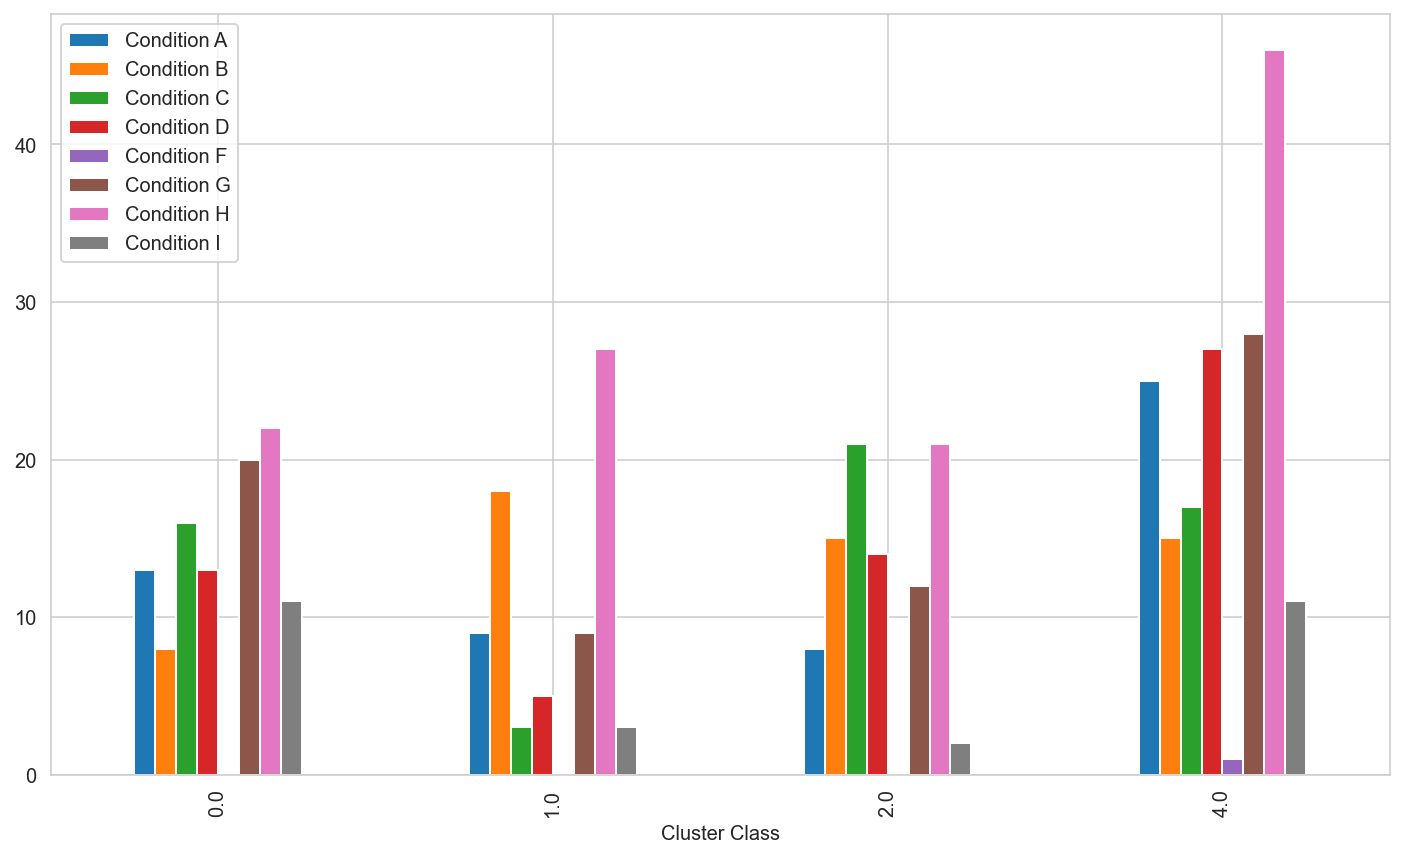

In [594]:
df_orders.groupby("Cluster Class").sum().plot(kind = "bar", figsize = [12, 7]);

Surprisingly there is no cluster 3 in the dataframe. This could be used by technicians in their configuration settings.

### YOUR DREAMS ARE VALID!!!

![Your Dreams Are Valid](Pictures/1642672173567.jpg)